In [1]:
## Import packages

import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.distributions import Normal

from eeyore.api import indexify
from eeyore.data import Iris
from eeyore.models import mlp
from eeyore.mcmc import MALA, PowerPosteriorSampler

from timeit import default_timer as timer
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Avoid issuing memory warning due to number of plots

plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
## Load iris data

num_chains = 10

dataloaders = [DataLoader(indexify(Iris)(), batch_size=150, shuffle=True) for i in range(num_chains)]

In [4]:
## Setup MLP model

hparams = mlp.Hyperparameters(dims=[4, 3, 3], activations=[torch.sigmoid, None])

models = [mlp.MLP(
    hparams=hparams,
    loss=lambda x, y: nn.CrossEntropyLoss(reduction='sum')(x, torch.argmax(y, 1)),
    dtype=torch.float64
) for i in range(num_chains)]

for i in range(num_chains):
    models[i].prior = Normal(
        torch.zeros(models[i].num_params(), dtype=models[i].dtype),
        np.sqrt(3)*torch.ones(models[i].num_params(), dtype=models[i].dtype)
    )

In [5]:
## Set initial values of chains

theta0 = models[num_chains-1].prior.sample()
theta0s = [theta0.clone().detach() for _ in range(num_chains)]

In [6]:
## Setup PowerPosteriorSampler

drift_step = 0.02
per_chain_samplers = num_chains * [['MALA', {'step': drift_step}]]
sampler = PowerPosteriorSampler(models, theta0s, dataloaders, per_chain_samplers, temperatures=num_chains*[1.])

In [7]:
## Run PowerPosteriorSampler

start_time = timer()

sampler.run(num_iterations=11000, num_burnin=1000, between_step=1)

end_time = timer()
print("Time taken: {}".format(timedelta(seconds=end_time-start_time)))

Time taken: 0:14:13.866937


In [8]:
## Compute Monte Carlo mean

sampler.get_chain().mean()

tensor([-0.5355, -0.6588, -0.4114,  1.0715,  0.2562,  0.3727,  0.3757,  0.6354,
        -0.3628, -1.5499,  1.8491,  0.1519, -0.9132, -0.6517,  0.8295, -1.3513,
        -0.3922, -3.2314, -0.6308, -0.8470,  1.9317,  1.2213,  1.5644,  0.5855,
         1.3803, -0.2951, -2.0354], dtype=torch.float64)

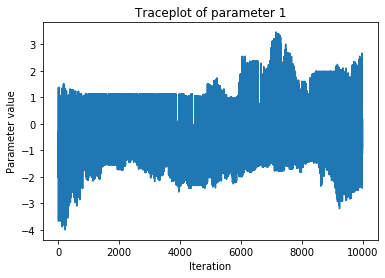

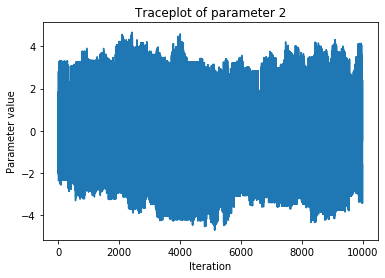

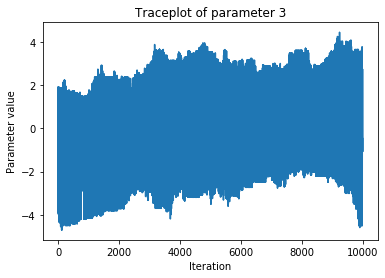

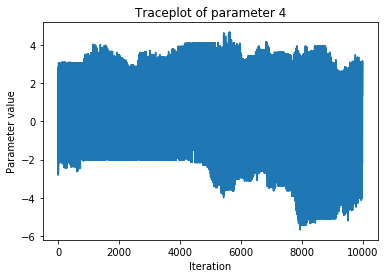

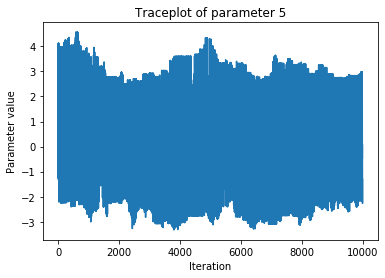

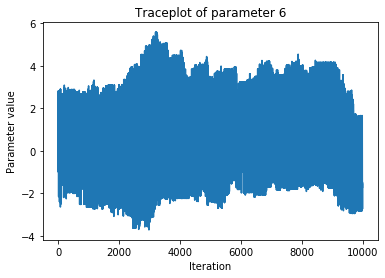

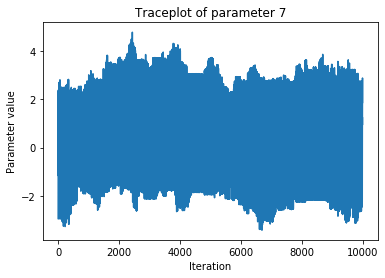

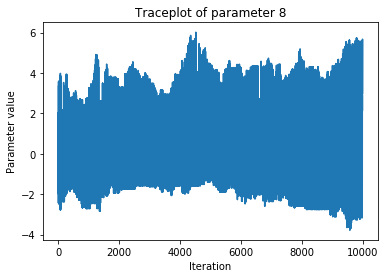

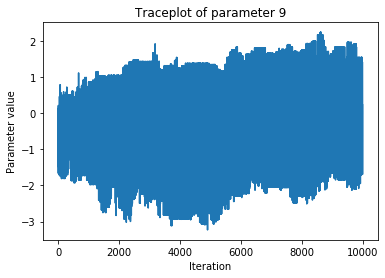

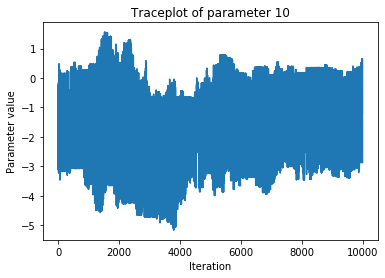

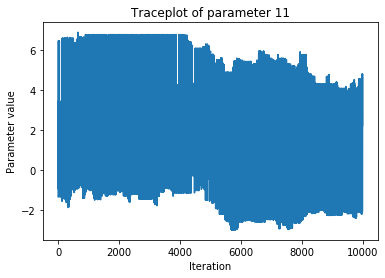

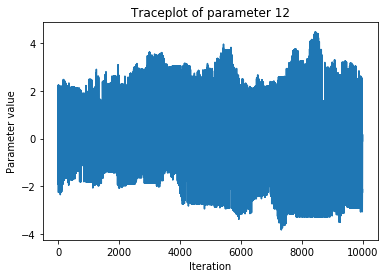

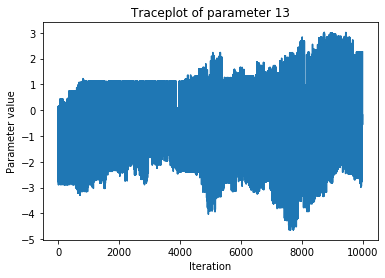

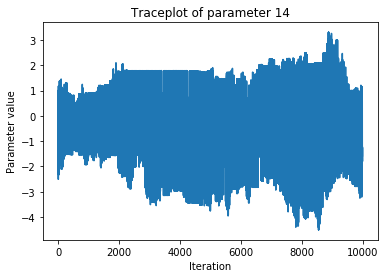

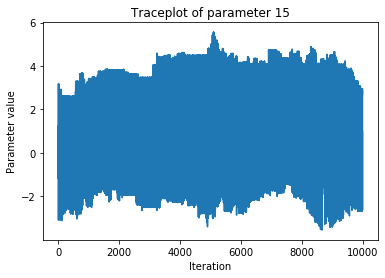

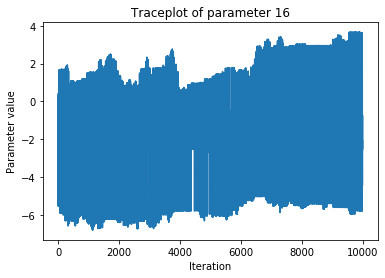

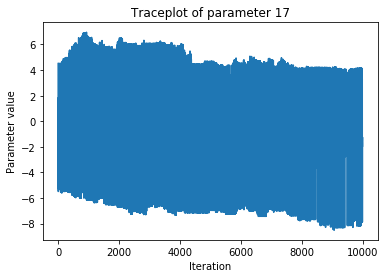

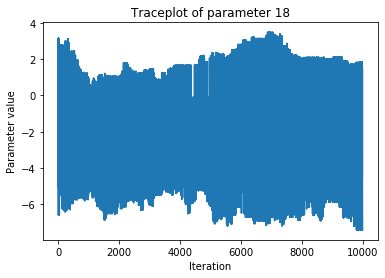

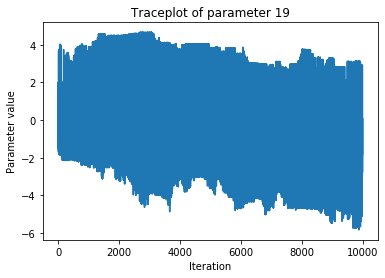

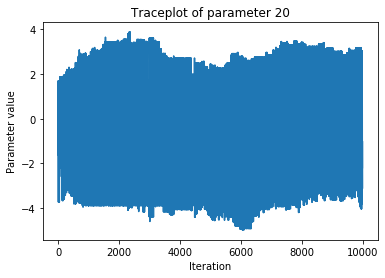

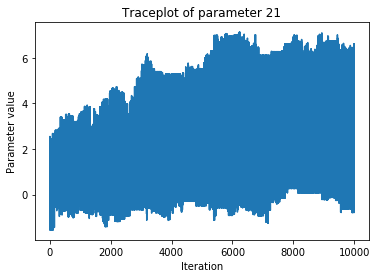

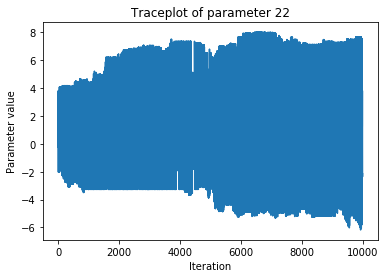

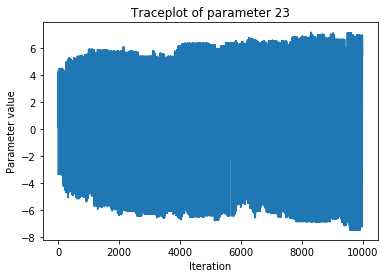

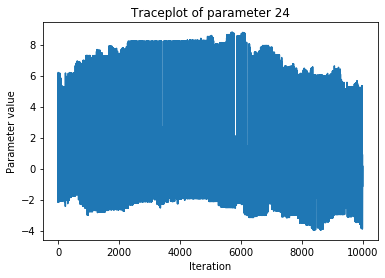

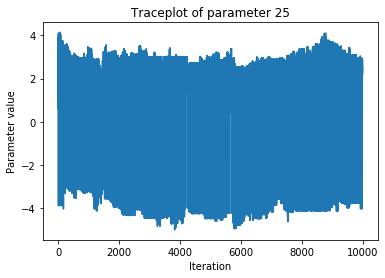

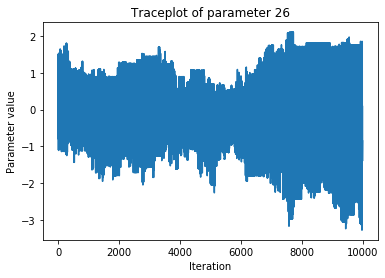

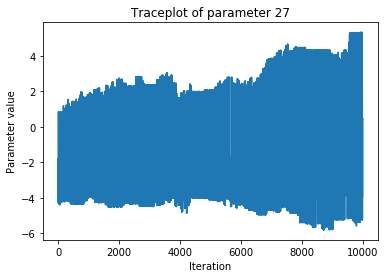

In [9]:
## Plot traces of simulated Markov chain

for i in range(sampler.models[0].num_params()):
    chain = sampler.get_chain().get_theta(i)
    plt.figure()
    sns.lineplot(range(len(chain)), chain)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Traceplot of parameter {}'.format(i+1))

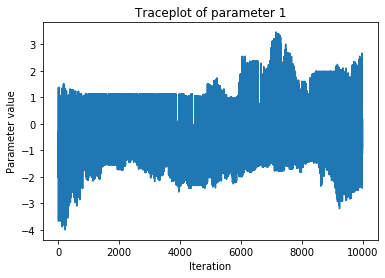

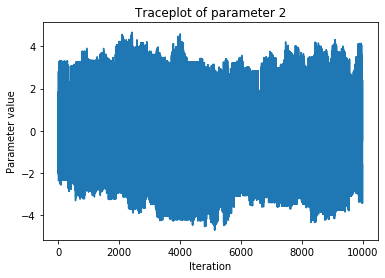

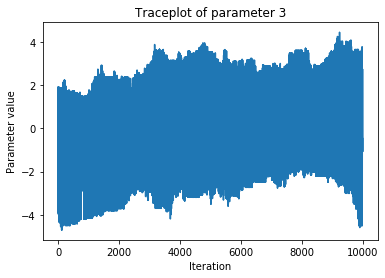

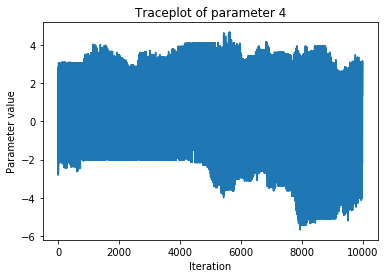

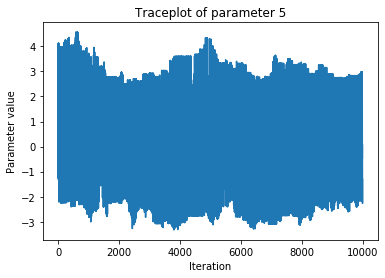

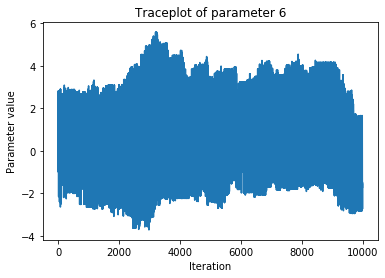

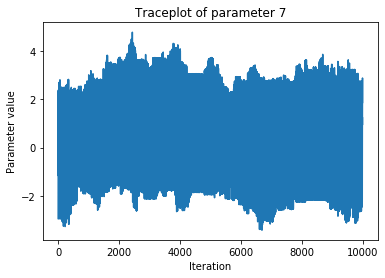

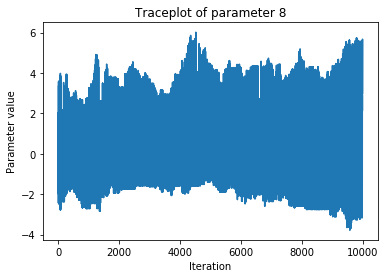

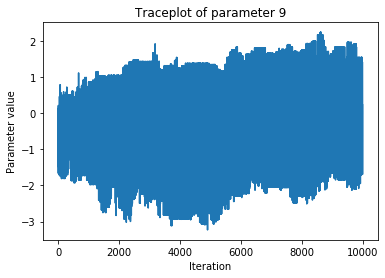

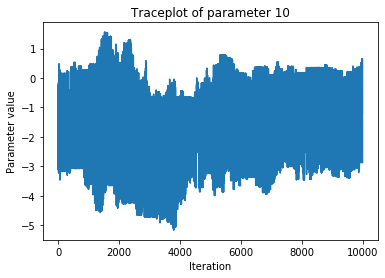

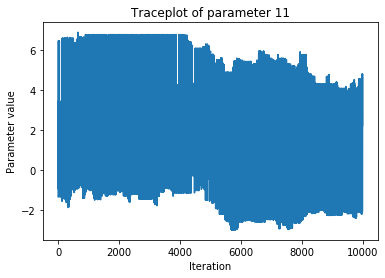

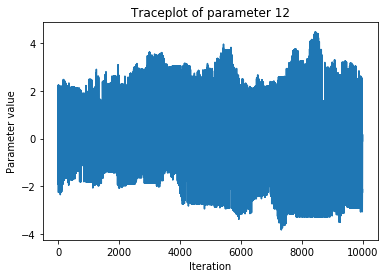

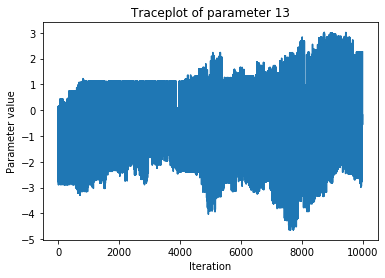

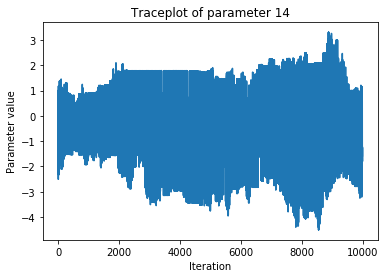

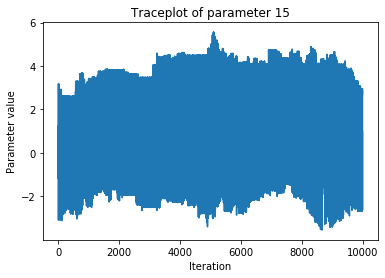

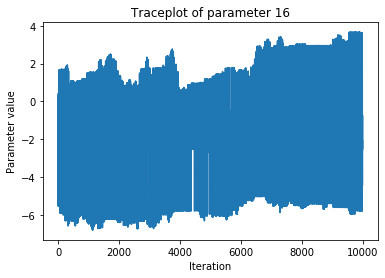

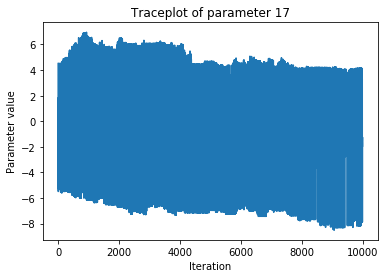

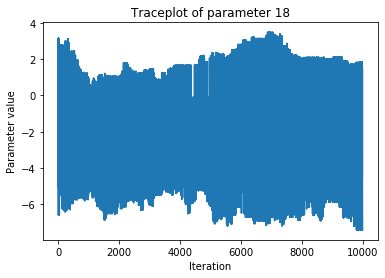

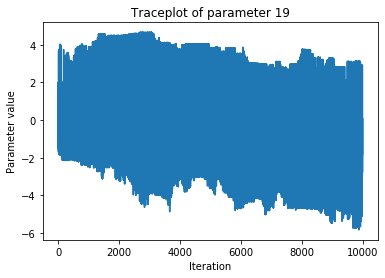

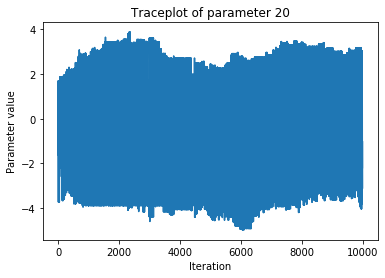

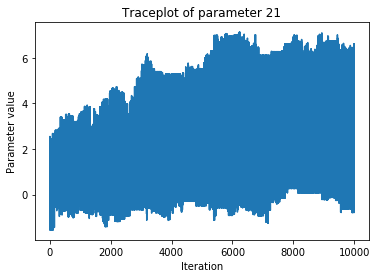

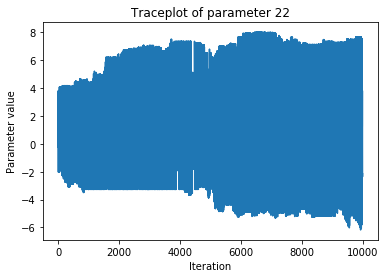

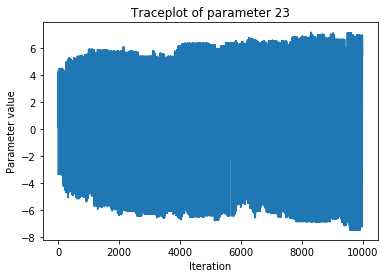

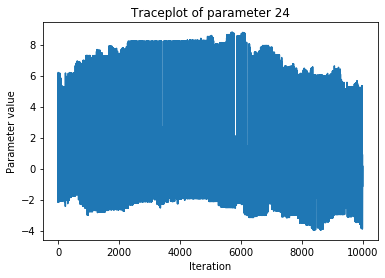

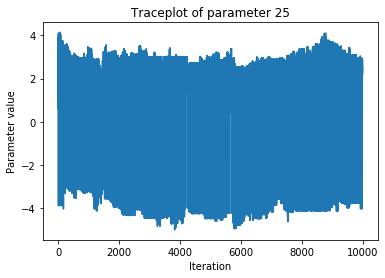

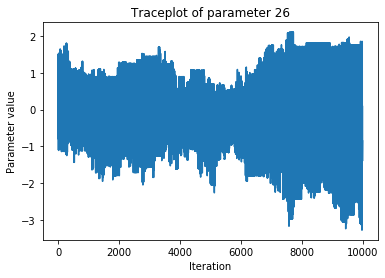

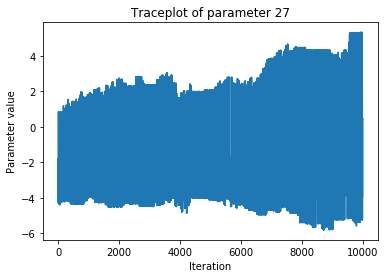

In [10]:
## Plot traces of simulated Markov chain

for i in range(sampler.models[0].num_params()):
    chain = sampler.get_chain().get_theta(i)
    plt.figure()
    sns.lineplot(range(len(chain)), chain)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Traceplot of parameter {}'.format(i+1))

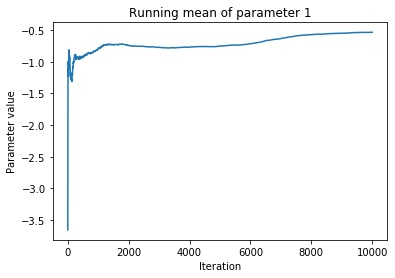

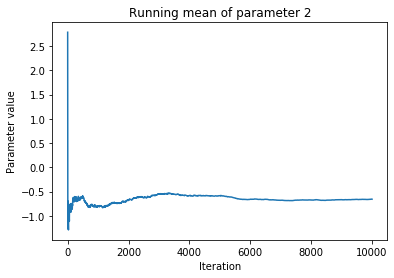

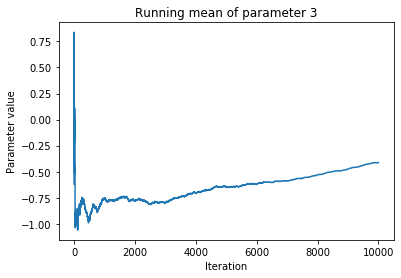

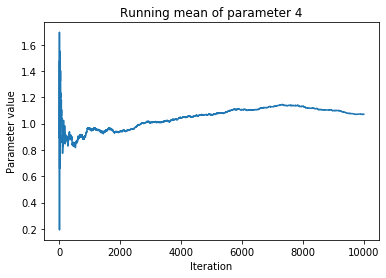

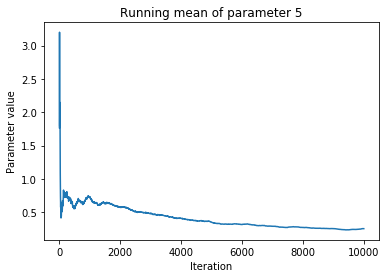

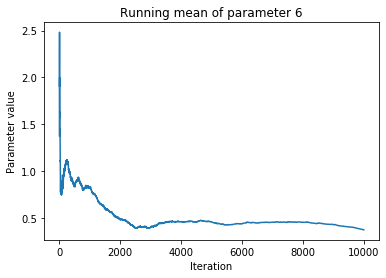

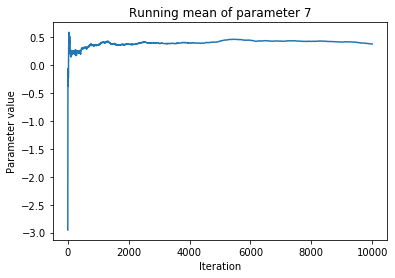

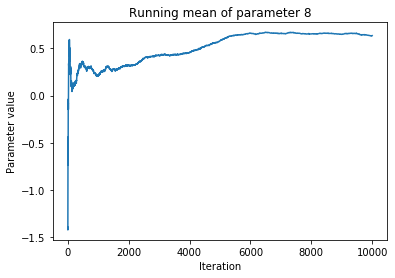

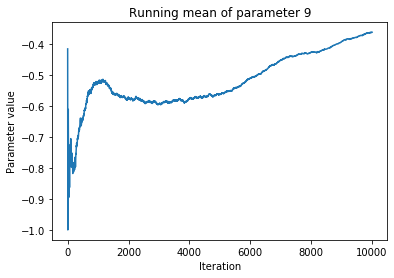

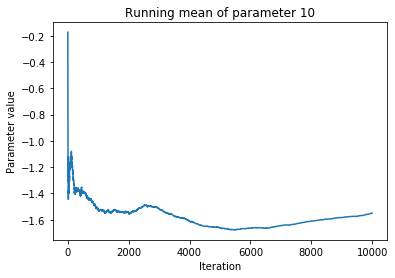

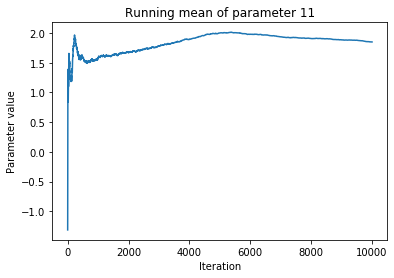

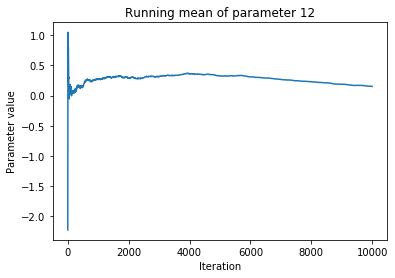

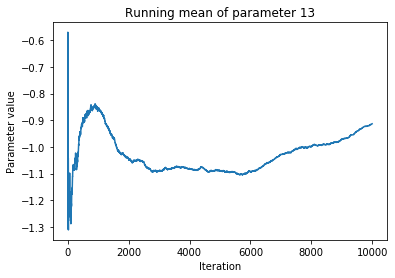

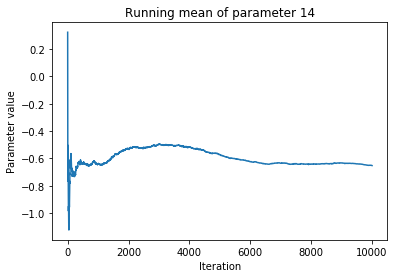

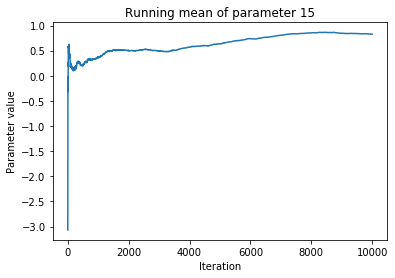

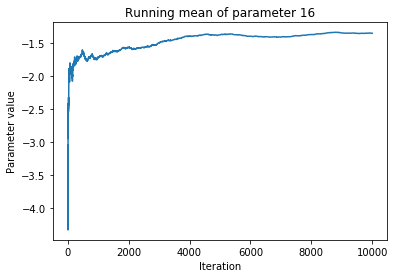

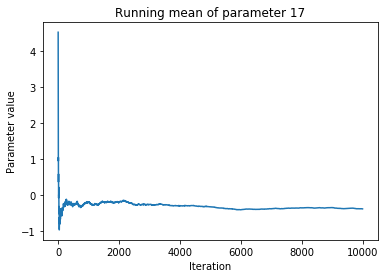

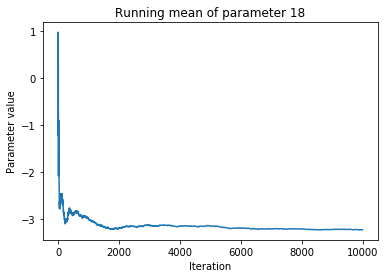

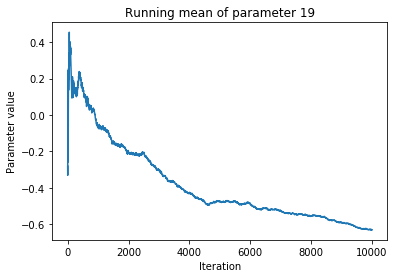

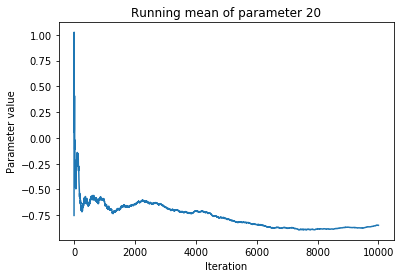

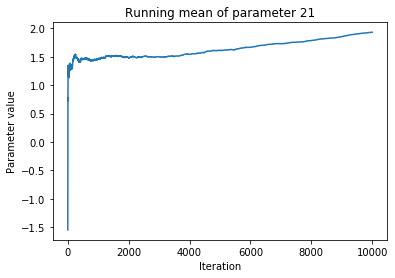

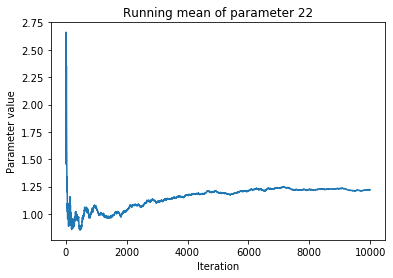

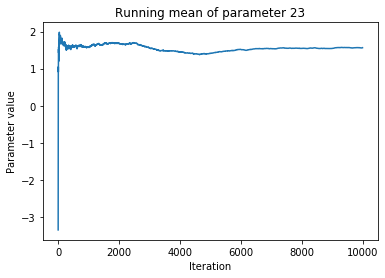

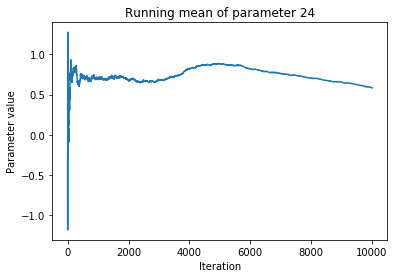

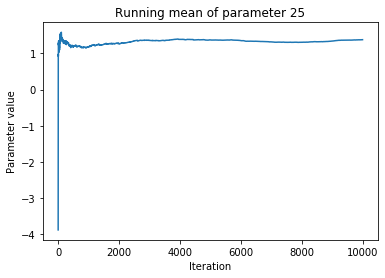

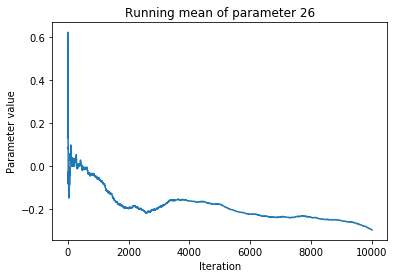

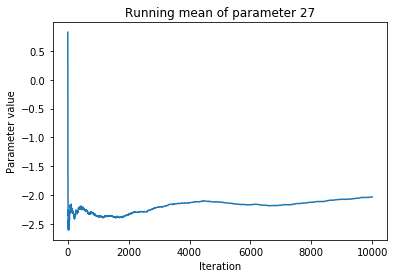

In [11]:
## Plot running means of simulated Markov chain

for i in range(models[0].num_params()):
    chain = sampler.get_chain().get_theta(i)
    chain_mean = torch.empty(len(chain))
    chain_mean[0] = chain[0]
    for j in range(1, len(chain)):
        chain_mean[j] = (chain[j]+j*chain_mean[j-1])/(j+1)
        
    plt.figure()
    sns.lineplot(range(len(chain)), chain_mean)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Running mean of parameter {}'.format(i+1))

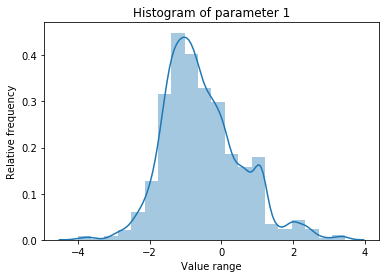

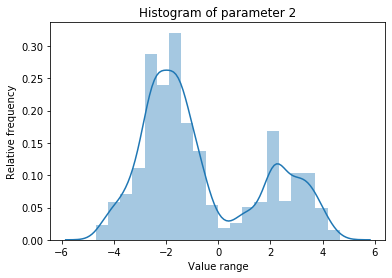

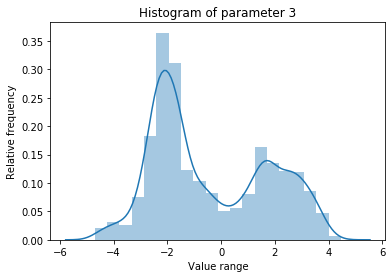

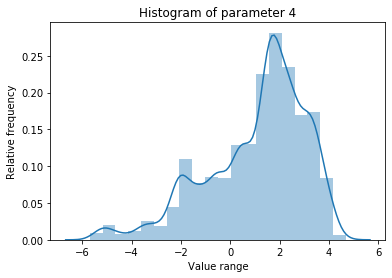

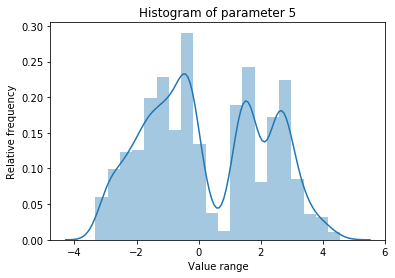

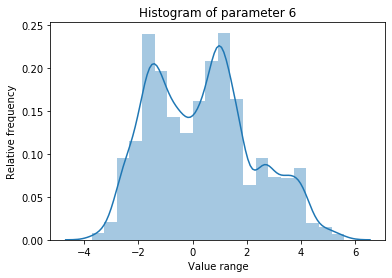

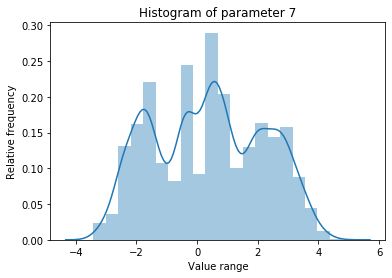

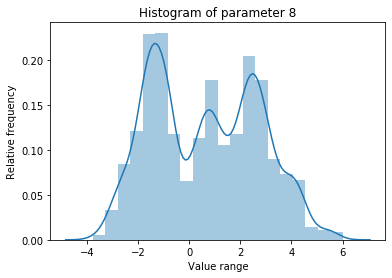

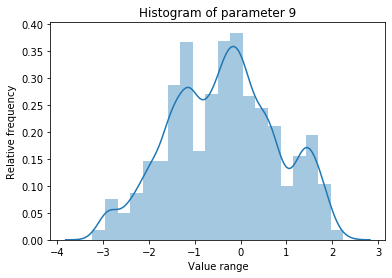

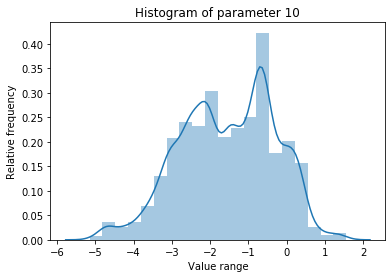

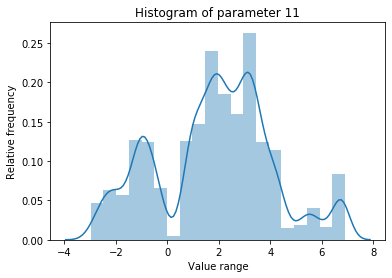

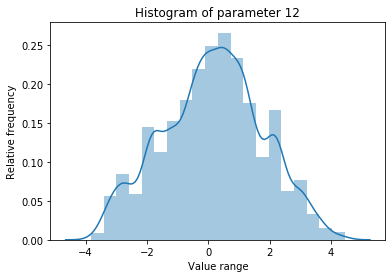

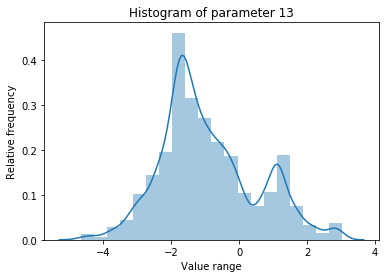

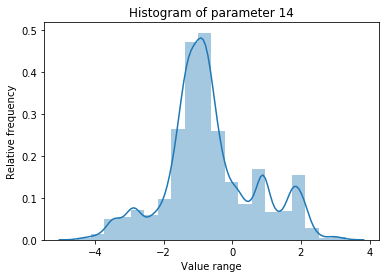

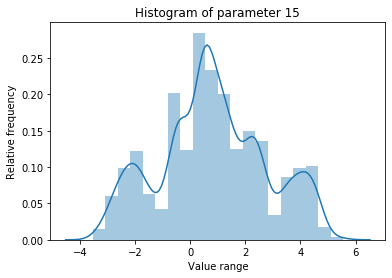

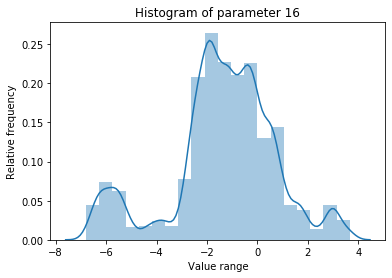

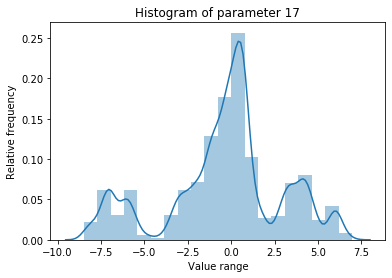

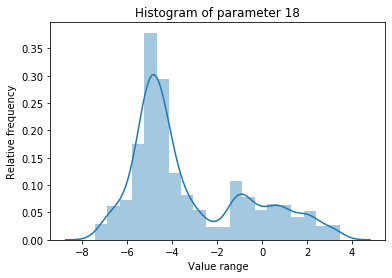

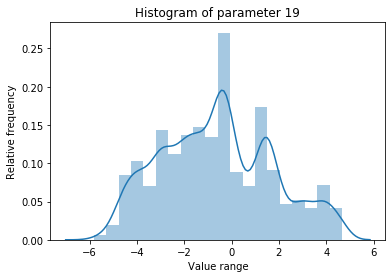

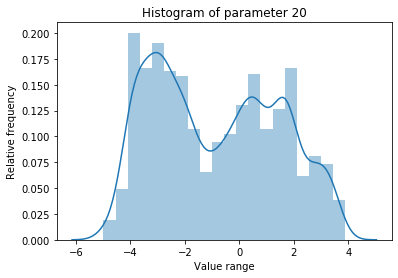

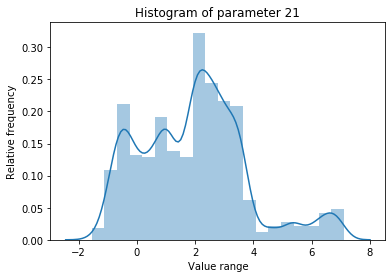

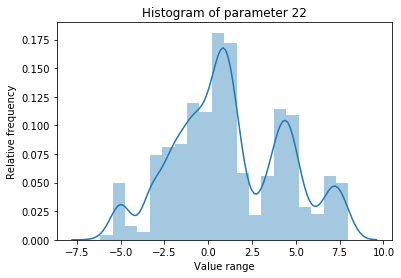

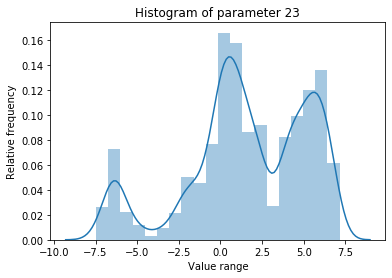

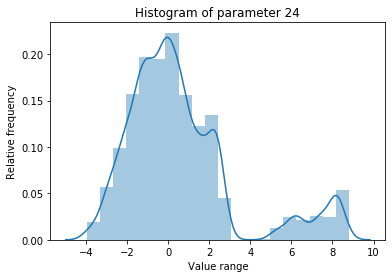

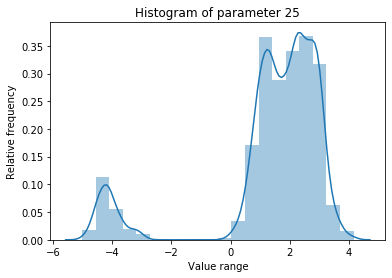

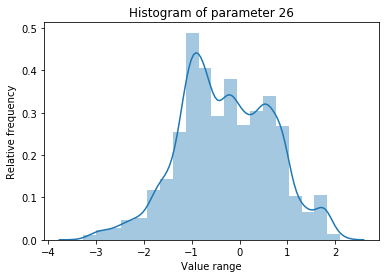

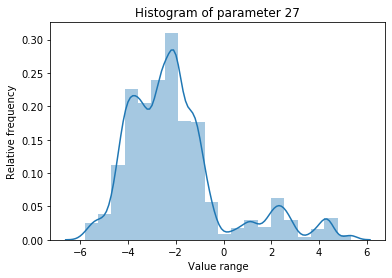

In [12]:
## Plot histograms of simulated Markov chain

for i in range(models[0].num_params()):
    plt.figure()
    sns.distplot(sampler.get_chain().get_theta(i), bins=20, norm_hist=True)
    plt.xlabel('Value range')
    plt.ylabel('Relative frequency')
    plt.title(r'Histogram of parameter {}'.format(i+1))